Генерация синтетических данных

In [9]:
import pandas as pd
import numpy as np

np.random.seed(42)

num_samples = 10000

data = pd.DataFrame({
    'pickup_datetime': pd.date_range(start='2023-01-01', periods=num_samples, freq='T'),
    'pickup_latitude': np.random.uniform(40.5, 40.9, num_samples),
    'pickup_longitude': np.random.uniform(-74.2, -73.7, num_samples),
    'trip_distance': np.random.uniform(0.5, 20, num_samples),
    'trip_duration': np.random.randint(60, 3600, num_samples)  # От 1 до 60 минут
})

data.to_csv('taxi_data.csv', index=False)
print("✅ Файл taxi_data.csv сгенерирован!")

✅ Файл taxi_data.csv сгенерирован!


/var/folders/gv/w8lzwcsd0_d7rgz4964mrrqr0000gn/T/ipykernel_60698/1247602591.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  'pickup_datetime': pd.date_range(start='2023-01-01', periods=num_samples, freq='T'),


In [10]:
pip install -r requirements.txt


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Импорт библиотек

В этом блоке мы импортируем все необходимые библиотеки для обработки данных, визуализации, построения моделей машинного обучения и интерпретации результатов.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
import shap
import lightgbm as lgb
import joblib

Загрузка данных

Загружаем датасет с данными о такси для дальнейшей обработки. Этот датасет содержит информацию о времени поездки, расстоянии, месте посадки и других параметрах.

In [13]:
data = pd.read_csv('taxi_data.csv')

Предобработка данных

Здесь мы выполняем обработку временных признаков, добавляя такие переменные как час дня, день недели, месяц и индикатор выходного дня. Мы также генерируем синусоидальные и косинусоидальные признаки для учёта цикличности времени суток. Затем удаляем строки с пропущенными значениями.


In [14]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['hour'] = data['pickup_datetime'].dt.hour
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
data['month'] = data['pickup_datetime'].dt.month
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
data['pickup_hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['pickup_hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data = data.dropna()

Фильтрация выбросов

Здесь мы фильтруем данные, убирая выбросы по времени поездки и расстоянию. Это помогает улучшить качество модели, исключив аномальные наблюдения.


In [15]:
data = data[(data['trip_duration'] > 60) & (data['trip_duration'] < 7200)]
data = data[(data['trip_distance'] > 0.5) & (data['trip_distance'] < 50)]

Визуализация точек посадки пассажиров

Мы визуализируем данные о точках посадки пассажиров на карте с использованием библиотеки Folium и создаём тепловую карту, которая отображает частоту посадок в разных районах города.

In [16]:
m = folium.Map(location=[data['pickup_latitude'].mean(), data['pickup_longitude'].mean()], zoom_start=12)
heat_data = list(zip(data['pickup_latitude'], data['pickup_longitude']))
HeatMap(heat_data).add_to(m)
m.save('pickup_heatmap.html')

Формирование признаков и разделение данных

В этом блоке мы выбираем признаки для обучения модели и разделяем данные на обучающую и тестовую выборки.

In [19]:
features = ['trip_distance', 'hour', 'day_of_week', 'month', 'is_weekend', 'pickup_hour_sin', 'pickup_hour_cos']
X = data[features]
y = data['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Определение моделей машинного обучения

Здесь мы определяем несколько регрессионных моделей, включая линейную регрессию, случайный лес, градиентный бустинг, XGBoost и LightGBM для дальнейшего обучения и оценки.

In [21]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=10),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42)
}

Обучение и оценка моделей

В этом блоке мы обучаем все модели на тренировочных данных и оцениваем их производительность по метрикам MAE, MSE и R2 на тестовых данных. Находим лучшую модель.


In [22]:
results = {}
best_model = None
best_score = float('inf')
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MAE': mae, 'MSE': mse, 'R2': r2}
    if mae < best_score:
        best_score = mae
        best_model = model
    print(f'{name}: MAE={mae:.2f}, MSE={mse:.2f}, R2={r2:.2f}')

Linear Regression: MAE=906.50, MSE=1085670.14, R2=-0.00
Ridge Regression: MAE=906.50, MSE=1085670.99, R2=-0.00
Lasso Regression: MAE=906.52, MSE=1085705.11, R2=-0.00
Random Forest: MAE=955.97, MSE=1271401.41, R2=-0.17
Gradient Boosting: MAE=903.46, MSE=1086048.16, R2=-0.00
KNN Regressor: MAE=934.01, MSE=1195510.52, R2=-0.10
XGBoost: MAE=952.12, MSE=1249394.26, R2=-0.15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 7999, number of used features: 6
[LightGBM] [Info] Start training from score 1824.419802
LightGBM: MAE=919.37, MSE=1129977.47, R2=-0.04


Визуализация результатов

Создаём график для визуализации сравнения моделей по метрике MAE.

/var/folders/gv/w8lzwcsd0_d7rgz4964mrrqr0000gn/T/ipykernel_60698/1470832584.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['MAE'], palette='viridis')


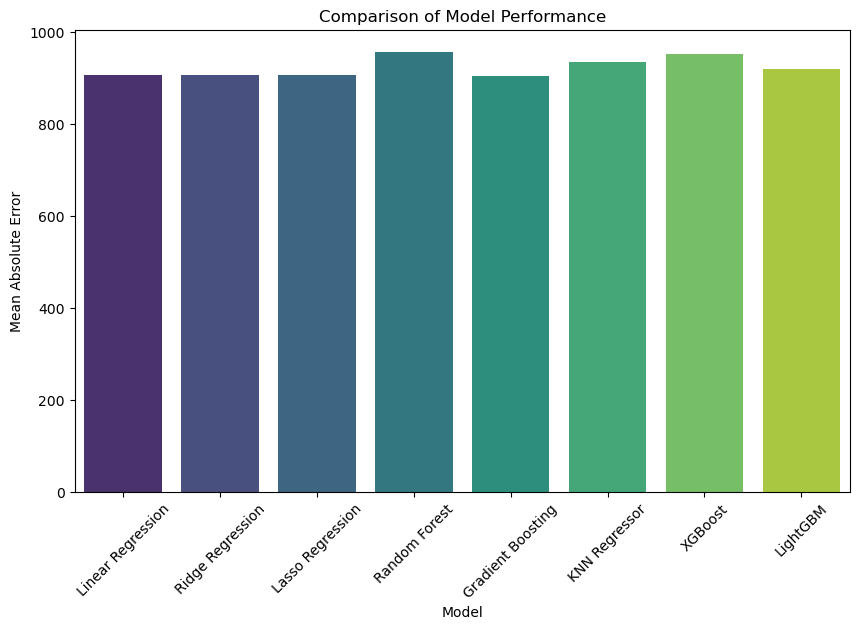

In [23]:
results_df = pd.DataFrame(results).T
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df['MAE'], palette='viridis')
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error')
plt.title('Comparison of Model Performance')
plt.xticks(rotation=45)
plt.show()

Визуализация предсказаний и реальных значений

Сравниваем распределения реальных и предсказанных значений времени поездки на гистограмме, чтобы увидеть, насколько хорошо модель предсказывает значения.

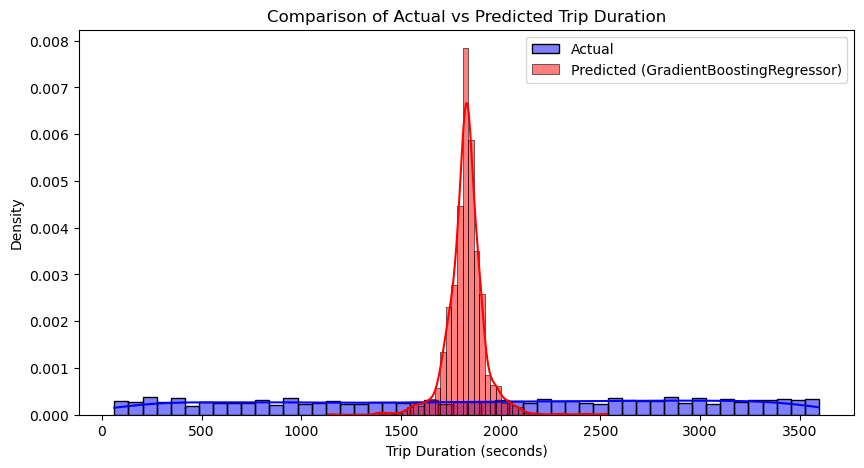

In [25]:
plt.figure(figsize=(10, 5))
sns.histplot(y_test, color='blue', label='Actual', kde=True, stat='density', bins=50)
sns.histplot(best_model.predict(X_test), color='red', label=f'Predicted ({best_model.__class__.__name__})', kde=True, stat='density', bins=50)
plt.legend()
plt.xlabel('Trip Duration (seconds)')
plt.title('Comparison of Actual vs Predicted Trip Duration')
plt.show()

Интерпретация модели с помощью SHAP

Используем SHAP для интерпретации модели и визуализации важности признаков.

/var/folders/gv/w8lzwcsd0_d7rgz4964mrrqr0000gn/T/ipykernel_60698/1222961650.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


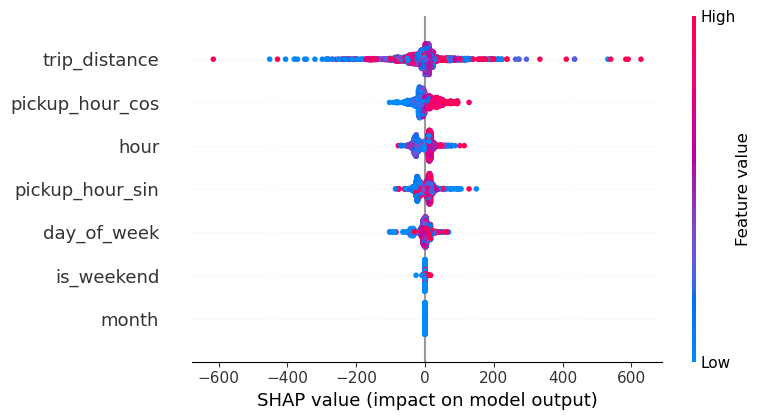

In [26]:
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

Сохранение модели

In [27]:
joblib.dump(best_model, 'best_taxi_model.pkl')

['best_taxi_model.pkl']